In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py, os, tqdm, glob
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.49'
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.utils import power_spectrum
from jaxpm.utils import _initialize_pk
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces
from jaxpm.kernels import fftk, gradient_kernel, invlaplace_kernel, longrange_kernel, invnabla_kernel
from jaxpm import camels

jax.devices("gpu")

[cuda(id=0)]

In [3]:
parts_per_dim = 64
mesh_per_dim = parts_per_dim
mesh_shape = [mesh_per_dim] * 3

SNAPSHOT = "/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0/snapshot_090.hdf5"

# density rho

In [4]:
with h5py.File(SNAPSHOT, "r") as data:
    box_size = data["Header"].attrs["BoxSize"] / 1e3  # size of the snapshot in comoving Mpc/h
    
    gas_pos = data["PartType0/Coordinates"][:] / 1e3  # Mpc/h
    gas_pos *= mesh_per_dim / box_size  # rescaling positions to grid coordinates

    gas_mass = data["PartType0/Masses"][:] * 1e10  # Msun/h

    # density
    gas_rho = data["PartType0/Density"][:] * 1e10 * (1e3) ** 3  # (Msun/h)/(Mpc/h)^3

In [5]:
def print_stats(array):
    print(f"mean = {array.mean():5e}")
    print(f"min = {array.min():5e}")
    print(f"max = {array.max():5e}")

In [6]:
rho_gas_pm = cic_paint(jnp.zeros([mesh_per_dim] * 3), gas_pos, gas_mass)
gas_rho_pm = cic_read(rho_gas_pm, gas_pos)
gas_rho_pm *= (mesh_per_dim / box_size) ** 3  # (Msun/h)/(Mpc/h)^3

2025-01-08 17:37:25.851029: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


mean = 6.787831e+13
min = 2.448290e+08
max = 6.211368e+18
mean = 5.434432e+11
min = 2.543974e+08
max = 1.457556e+13


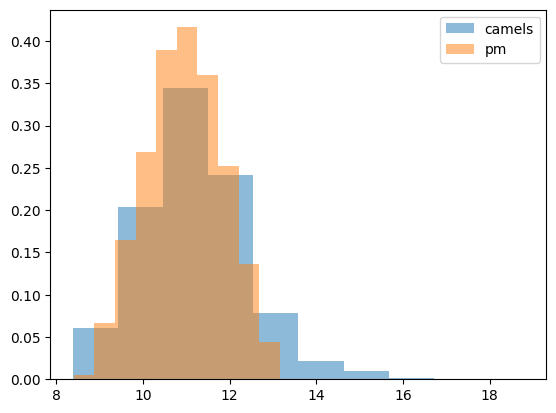

In [7]:
print_stats(gas_rho)
print_stats(gas_rho_pm)
plt.hist(np.log10(gas_rho), alpha=0.5, density=True, label="camels")
plt.hist(np.log10(gas_rho_pm), alpha=0.5, density=True, label="pm")
plt.legend()

# pressure P

In [8]:
with h5py.File(SNAPSHOT, "r") as data:
    box_size = data["Header"].attrs["BoxSize"] / 1e3  # size of the snapshot in comoving Mpc/h
    
    gas_pos = data["PartType0/Coordinates"][:] / 1e3  # Mpc/h
    gas_pos *= mesh_per_dim / box_size  # rescaling positions to grid coordinates

    gas_mass = data["PartType0/Masses"][:] * 1e10  # Msun/h

    # density
    gas_rho = data["PartType0/Density"][:] * 1e10 * (1e3) ** 3  # (Msun/h)/(Mpc/h)^3

    # pressure
    gamma = 5.0 / 3.0
    gas_U = data["PartType0/InternalEnergy"][:]  # (km/s)^2
    gas_P = (gamma - 1.0) * gas_U * gas_rho  # units are (Msun/h)*(km/s)^2/(Mpc/h)^3

In [9]:
P_gas_pm = cic_paint(jnp.zeros([mesh_per_dim] * 3), gas_pos, (gamma - 1.0) * gas_mass * gas_U)
gas_P_pm = cic_read(P_gas_pm, gas_pos)  # units are
gas_P_pm *= (mesh_per_dim / box_size) ** 3

mean = 1.394123e+17
min = 7.215583e+09
max = 1.796200e+22
mean = 4.513338e+16
min = 7.475894e+09
max = 2.655331e+18


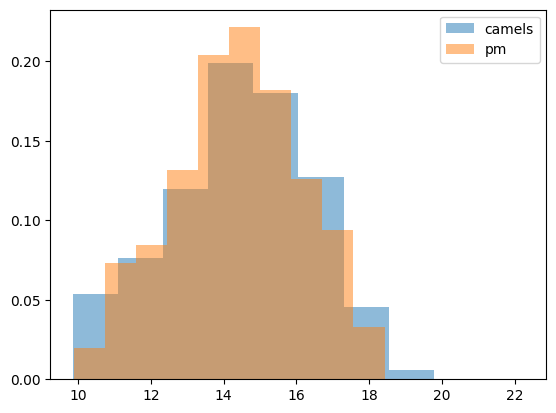

In [10]:
print_stats(gas_P)
print_stats(gas_P_pm)
plt.hist(np.log10(gas_P), alpha=0.5, density=True, label="camels")
plt.hist(np.log10(gas_P_pm), alpha=0.5, density=True, label="pm")
plt.legend()